In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [3]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import time


import warnings
warnings.filterwarnings(action="ignore")

To collect the data, I used the Realtor.com Scraper through APIFY (https://console.apify.com/actors/GctCXDim0MXeLZegY/console) to scrape recently sold properties in Orlando, FL and for the greater Central Florida region.

First we will clean and work with the data for Orlando to build the local model.

# Local Model: Data Cleaning

In [4]:
#import dataset
df = pd.read_csv('/content/drive/MyDrive/kaggle/Realtor-ORL-sold.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4787 entries, 0 to 4786
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address/locality    4787 non-null   object 
 1   address/postalCode  4787 non-null   int64  
 2   address/region      4787 non-null   object 
 3   address/street      4753 non-null   object 
 4   lastSoldPrice       4787 non-null   int64  
 5   type                4787 non-null   object 
 6   sqft                4450 non-null   float64
 7   lot_sqft            4424 non-null   float64
 8   beds                4441 non-null   float64
 9   baths_full_calc     4433 non-null   float64
 10  baths_total         201 non-null    float64
 11  garage              2820 non-null   float64
 12  year_built          4419 non-null   float64
dtypes: float64(7), int64(2), object(4)
memory usage: 486.3+ KB


In [6]:
df.head(15)

,address/locality,address/postalCode,address/region,address/street,lastSoldPrice,type,sqft,lot_sqft,beds,baths_full_calc,baths_total,garage,year_built
0,Orlando,32824,FL,14319 Fieldstone Lake Way,447500,single_family,1622.0,10019.0,3.0,2.0,NaN,2.0,2007.0
1,Orlando,32822,FL,4405 S Semoran Blvd Apt 8,190000,condos,1426.0,5660.0,3.0,2.0,NaN,NaN,1974.0
2,Orlando,32807,FL,725 Thalia Dr,325000,single_family,1190.0,9112.0,3.0,2.0,NaN,NaN,1957.0
3,Orlando,32811,FL,4450 Middlebrook Rd # 4,187000,condos,1093.0,11761.0,2.0,2.0,NaN,NaN,1984.0
4,Orlando,32803,FL,1710 Oregon St,675000,single_family,1940.0,7791.0,4.0,2.0,NaN,NaN,1949.0
5,Orlando,32825,FL,2509 Stonewood Estates Ln,500000,single_family,2222.0,6662.0,4.0,3.0,NaN,2.0,2001.0
6,Orlando,32810,FL,3319 Jujube Dr,337000,single_family,1073.0,7702.0,3.0,2.0,NaN,1.0,1984.0
7,Orlando,32804,FL,2 W Spruce St,465000,single_family,1363.0,6920.0,3.0,2.0,NaN,1.0,1952.0
8,Orlando,32825,FL,9477 Brackin St,359000,single_family,1563.0,4379.0,3.0,2.0,NaN,1.0,1995.0
9,Orlando,32806,FL,318 E Kaley St,365000,single_family,1192.0,6817.0,2.0,2.0,NaN,NaN,1941.0


In [7]:
df1 = df.drop(['address/locality', 'address/region'], axis=1)

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4787 entries, 0 to 4786
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address/postalCode  4787 non-null   int64  
 1   address/street      4753 non-null   object 
 2   lastSoldPrice       4787 non-null   int64  
 3   type                4787 non-null   object 
 4   sqft                4450 non-null   float64
 5   lot_sqft            4424 non-null   float64
 6   beds                4441 non-null   float64
 7   baths_full_calc     4433 non-null   float64
 8   baths_total         201 non-null    float64
 9   garage              2820 non-null   float64
 10  year_built          4419 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 411.5+ KB


There are a lot of null values in this dataset, but it looks like a lot of them are things that can be filled in (ex: for 'garage' a null value would mean no garage, which can be written in as a 0).


The baths_total feature doesn't look like it will be helpful since it has so many null values so we can drop that

In [9]:
df1 = df1.drop(['baths_total'], axis =1)

The nulls in the 'garage' variable are just indicating that there is no garage, so we can set these to 0


In [10]:
df1["garage"].fillna(0, inplace=True)

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4787 entries, 0 to 4786
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address/postalCode  4787 non-null   int64  
 1   address/street      4753 non-null   object 
 2   lastSoldPrice       4787 non-null   int64  
 3   type                4787 non-null   object 
 4   sqft                4450 non-null   float64
 5   lot_sqft            4424 non-null   float64
 6   beds                4441 non-null   float64
 7   baths_full_calc     4433 non-null   float64
 8   garage              4787 non-null   float64
 9   year_built          4419 non-null   float64
dtypes: float64(6), int64(2), object(2)
memory usage: 374.1+ KB


In [12]:
df1['type'].unique()

array(['single_family', 'condos', 'townhomes', 'land', 'multi_family',
       'mobile', 'condo', 'other'], dtype=object)

In [13]:
df1['type'].value_counts()

type
single_family    2937
condos            818
townhomes         408
land              309
multi_family      112
mobile            108
condo              71
other              24
Name: count, dtype: int64

Looking at the unique values for the property type, we see that there are some properties that are empty lots and some listed as 'other'. We can drop the listings that are 'other.



In [14]:
#drop lines where 'type' = 'other'

df1 = df1.drop(df1[df1['type'] == 'other'].index)

In [15]:
df1['type'].value_counts()

type
single_family    2937
condos            818
townhomes         408
land              309
multi_family      112
mobile            108
condo              71
Name: count, dtype: int64

We can also see that some properties are labeled 'condos' and others 'condo'. So let's relabel them all into 'condo'

In [16]:
df1 = df1.replace(to_replace=r'condos', value='condo', regex=True)

In [17]:
df1['type'].value_counts()

type
single_family    2937
condo             889
townhomes         408
land              309
multi_family      112
mobile            108
Name: count, dtype: int64

Let's look at the nulls that we noticed for the 'land' properties. For these we should set the sqft, beds, and baths to 0, and the yearbuilt we can set to the current year (presuming that if the land was purchased now, construction would be complete this year)

In [18]:
#separate the values for land type properties
land = (df1[df1['type'] == 'land'])
land.head(12)

,address/postalCode,address/street,lastSoldPrice,type,sqft,lot_sqft,beds,baths_full_calc,garage,year_built
31,32820,5120 Dill Rd,15000,land,NaN,51836.0,NaN,NaN,0.0,NaN
67,32820,1801 Dill Rd,12000,land,NaN,50094.0,NaN,NaN,0.0,NaN
69,32804,1402 Stetson St,512500,land,NaN,10019.0,NaN,NaN,0.0,NaN
77,32833,Overton St,60000,land,NaN,44867.0,NaN,NaN,0.0,NaN
119,32820,700 Dill Rd,13000,land,NaN,55321.0,NaN,NaN,0.0,NaN
186,32828,15497 Larkspur St,170000,land,NaN,17860.0,NaN,NaN,0.0,NaN
277,32833,Tract 21 Sheldon St,115000,land,NaN,66211.0,NaN,NaN,0.0,NaN
278,32833,Lott 53 Moorgate St,75000,land,NaN,54014.0,NaN,NaN,0.0,NaN
279,32803,0 Eldridge St,92500,land,NaN,5964.0,NaN,NaN,0.0,NaN
295,32833,5900 Brentford Ave,90000,land,NaN,44867.0,NaN,NaN,0.0,NaN


In [19]:
#replace null values for sqft, beds, baths with 0 and set year_built to this year
land['sqft'] .fillna(0, inplace = True)
land['beds'] .fillna(0, inplace = True)
land['baths_full_calc'] .fillna(0, inplace = True)
land['year_built'] .fillna(2024, inplace = True)

In [20]:
land.head(12)

,address/postalCode,address/street,lastSoldPrice,type,sqft,lot_sqft,beds,baths_full_calc,garage,year_built
31,32820,5120 Dill Rd,15000,land,0.0,51836.0,0.0,0.0,0.0,2024.0
67,32820,1801 Dill Rd,12000,land,0.0,50094.0,0.0,0.0,0.0,2024.0
69,32804,1402 Stetson St,512500,land,0.0,10019.0,0.0,0.0,0.0,2024.0
77,32833,Overton St,60000,land,0.0,44867.0,0.0,0.0,0.0,2024.0
119,32820,700 Dill Rd,13000,land,0.0,55321.0,0.0,0.0,0.0,2024.0
186,32828,15497 Larkspur St,170000,land,0.0,17860.0,0.0,0.0,0.0,2024.0
277,32833,Tract 21 Sheldon St,115000,land,0.0,66211.0,0.0,0.0,0.0,2024.0
278,32833,Lott 53 Moorgate St,75000,land,0.0,54014.0,0.0,0.0,0.0,2024.0
279,32803,0 Eldridge St,92500,land,0.0,5964.0,0.0,0.0,0.0,2024.0
295,32833,5900 Brentford Ave,90000,land,0.0,44867.0,0.0,0.0,0.0,2024.0


In [21]:
land.info()

<class 'pandas.core.frame.DataFrame'>
Index: 309 entries, 31 to 4755
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address/postalCode  309 non-null    int64  
 1   address/street      309 non-null    object 
 2   lastSoldPrice       309 non-null    int64  
 3   type                309 non-null    object 
 4   sqft                309 non-null    float64
 5   lot_sqft            139 non-null    float64
 6   beds                309 non-null    float64
 7   baths_full_calc     309 non-null    float64
 8   garage              309 non-null    float64
 9   year_built          309 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 26.6+ KB


Looking at the info for the land type properties, we see that about half of them are missing values for lot square ft. We can drop these once these lines are added back into the main dataframe

In [22]:
#combine the main dataframe with the dataframe 'land' where we filled in the missing values
df_clean = pd.concat([df1, land], axis=0)

In [23]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5072 entries, 0 to 4755
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address/postalCode  5072 non-null   int64  
 1   address/street      5038 non-null   object 
 2   lastSoldPrice       5072 non-null   int64  
 3   type                5072 non-null   object 
 4   sqft                4742 non-null   float64
 5   lot_sqft            4541 non-null   float64
 6   beds                4749 non-null   float64
 7   baths_full_calc     4741 non-null   float64
 8   garage              5072 non-null   float64
 9   year_built          4711 non-null   float64
dtypes: float64(6), int64(2), object(2)
memory usage: 435.9+ KB


Since we have combined the values from 'land' with the main dataframe, there are some properties that are now duplicates (the original 'land' type listings with null values, and the ones with filled in values from the land dataframe). We also have a few other properties that have some null values. So now we can drop lines that have null values, which should take care of the duplicates as well as any other listings that had missing information.

It looks like we only have a handful of nulls left in the dataframe, but since we have a lot of data those should be fine to drop.

In [24]:
#drop lines that have null values
df_clean = df_clean.dropna()

In [25]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4350 entries, 0 to 4755
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address/postalCode  4350 non-null   int64  
 1   address/street      4350 non-null   object 
 2   lastSoldPrice       4350 non-null   int64  
 3   type                4350 non-null   object 
 4   sqft                4350 non-null   float64
 5   lot_sqft            4350 non-null   float64
 6   beds                4350 non-null   float64
 7   baths_full_calc     4350 non-null   float64
 8   garage              4350 non-null   float64
 9   year_built          4350 non-null   float64
dtypes: float64(6), int64(2), object(2)
memory usage: 373.8+ KB


The street address is not really needed, so we can drop that

In [26]:
# drop street address
df_clean = df_clean.drop(['address/street'], axis = 1)

In [27]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4350 entries, 0 to 4755
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address/postalCode  4350 non-null   int64  
 1   lastSoldPrice       4350 non-null   int64  
 2   type                4350 non-null   object 
 3   sqft                4350 non-null   float64
 4   lot_sqft            4350 non-null   float64
 5   beds                4350 non-null   float64
 6   baths_full_calc     4350 non-null   float64
 7   garage              4350 non-null   float64
 8   year_built          4350 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 339.8+ KB


Now that we have clean data with no more nulls or missing information, we can start looking at outliers and possible errors by looking at the distribution of the various features.

# Local Model: Data Exploration (outliers and errors)

Let's look at boxplots for each of the features to see if there are any outliers that we should evaluate

<Axes: >

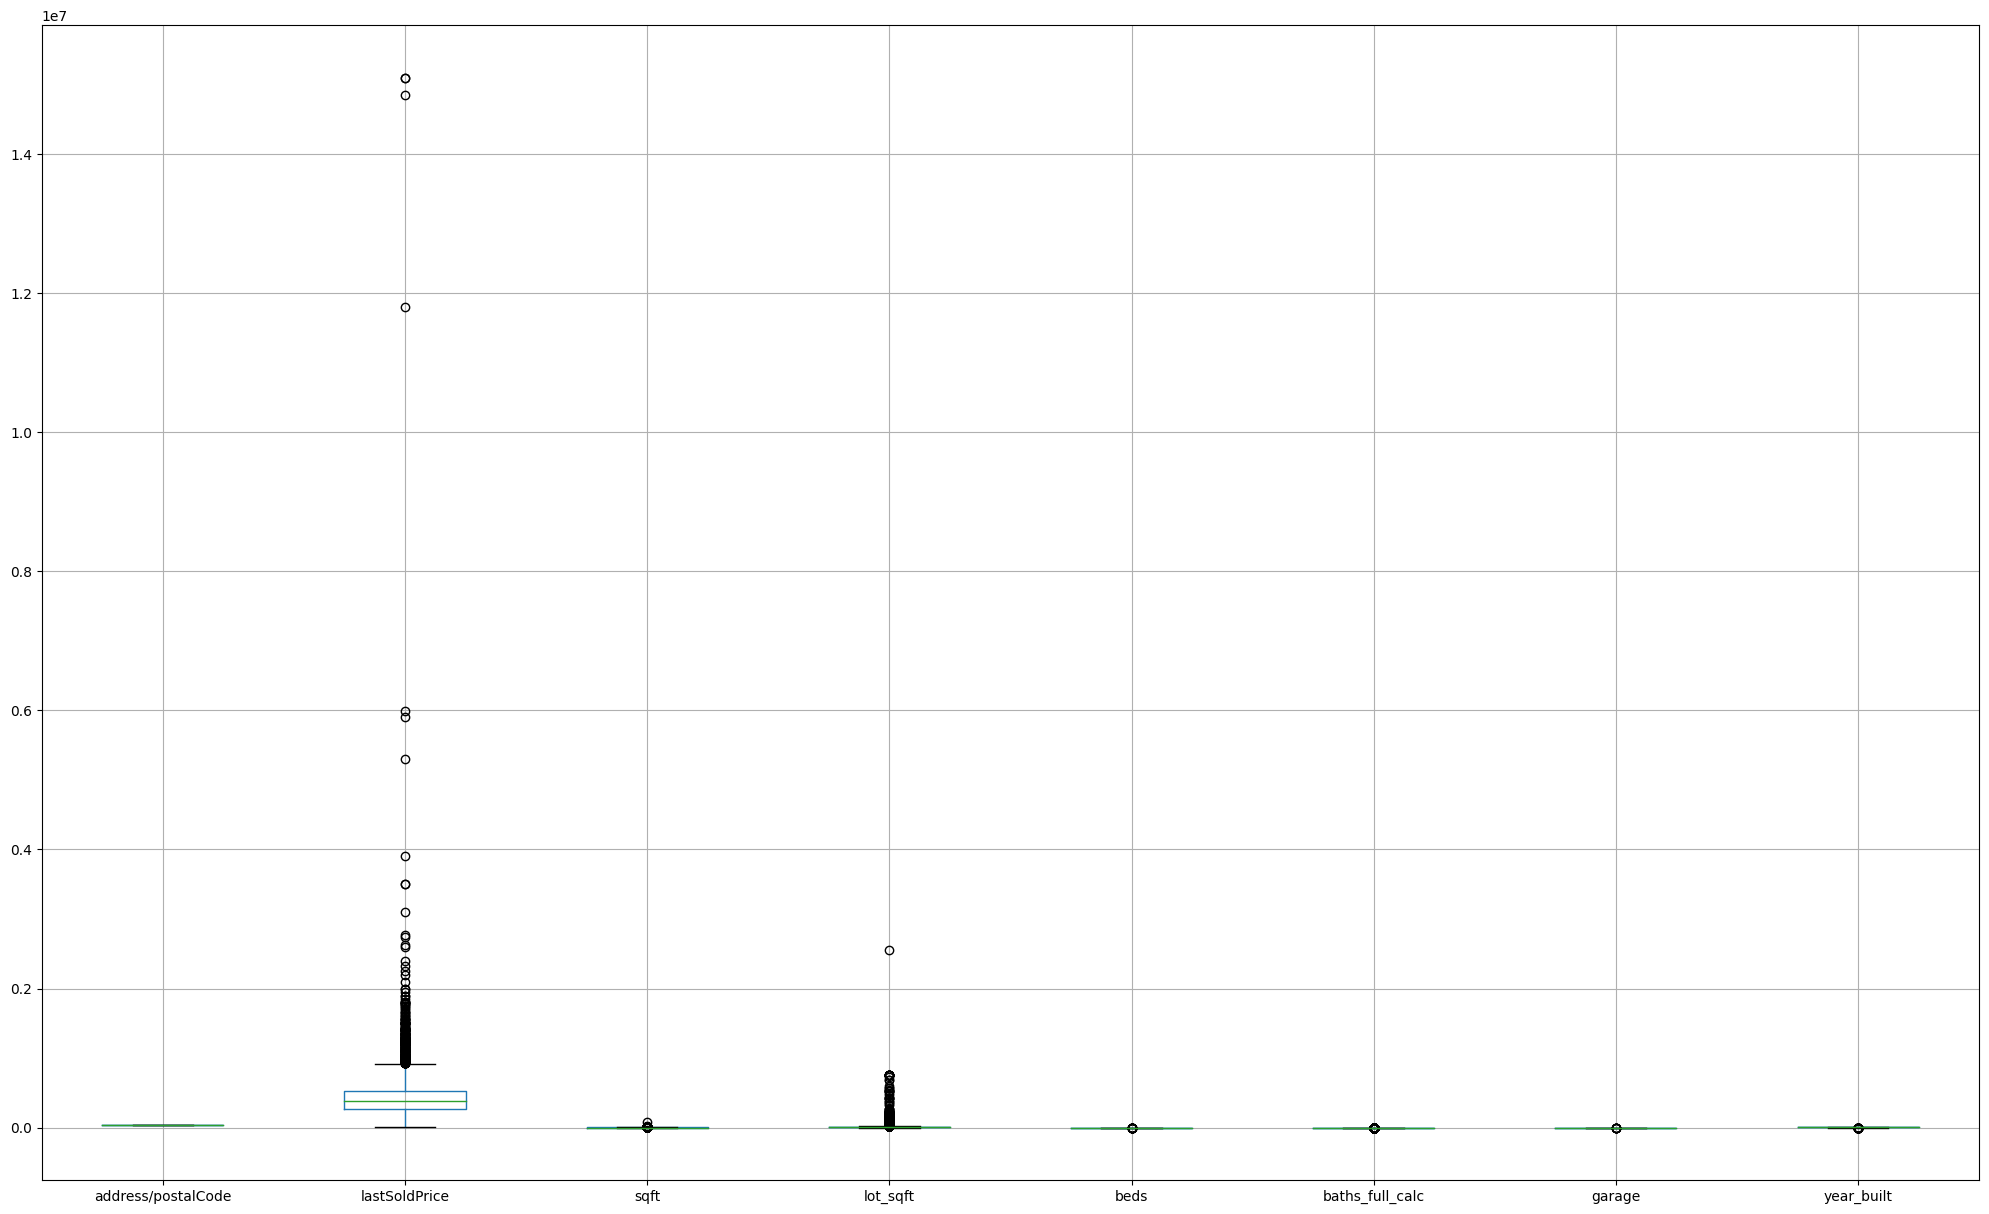

In [28]:
# check for outliers
plt.figure(figsize=(25,15))
df_clean.boxplot()

It looks like there are some huge outliers in the 'lastSoldPrice' feature, and a bunch of outliers in lot_sqft, so let's look at those more closely

In [29]:
#print listings where the lastSoldPrice is over 3 million
print(df_clean[df_clean['lastSoldPrice'] > 3000000])

      address/postalCode  lastSoldPrice           type     sqft  lot_sqft  \
23                 32814        3500000  single_family   5273.0   16117.0   
131                32819       11800000  single_family  20690.0   79715.0   
588                32836        3500000  single_family   7005.0   11326.0   
1205               32805        3900000  single_family   1406.0    6934.0   
1444               32804        5300000  single_family   8173.0   36590.0   
2411               32827        5900000  single_family   8245.0   30928.0   
2427               32827        5995000  single_family   7740.0   31363.0   
3960               32832       15100000  single_family   3301.0  231739.0   
4303               32839       14850000   multi_family  85860.0  341676.0   
2434               32822        3100000           land      0.0  168142.0   
3968               32832       15100000           land      0.0  319730.0   

      beds  baths_full_calc  garage  year_built  
23     5.0              5

In [30]:
# drop the listings that were over 3 million

df_clean = df_clean.drop([23,131,588,1205,1444,2411,2427,3960,4303,2434,3968])


One of the outliers for lot_sqft shows over 2 million sqft lot size (about 46 acres), which is pretty huge compared to even the other outliers, so let's remove that

In [31]:
print(df_clean[df_clean['lot_sqft'] > 2000000])

      address/postalCode  lastSoldPrice  type  sqft   lot_sqft  beds  \
3440               32820        1100000  land   0.0  2559150.0   0.0   

      baths_full_calc  garage  year_built  
3440              0.0     0.0      2024.0  


In [32]:
# drop row 3440
df_clean = df_clean.drop([3440])


<Axes: >

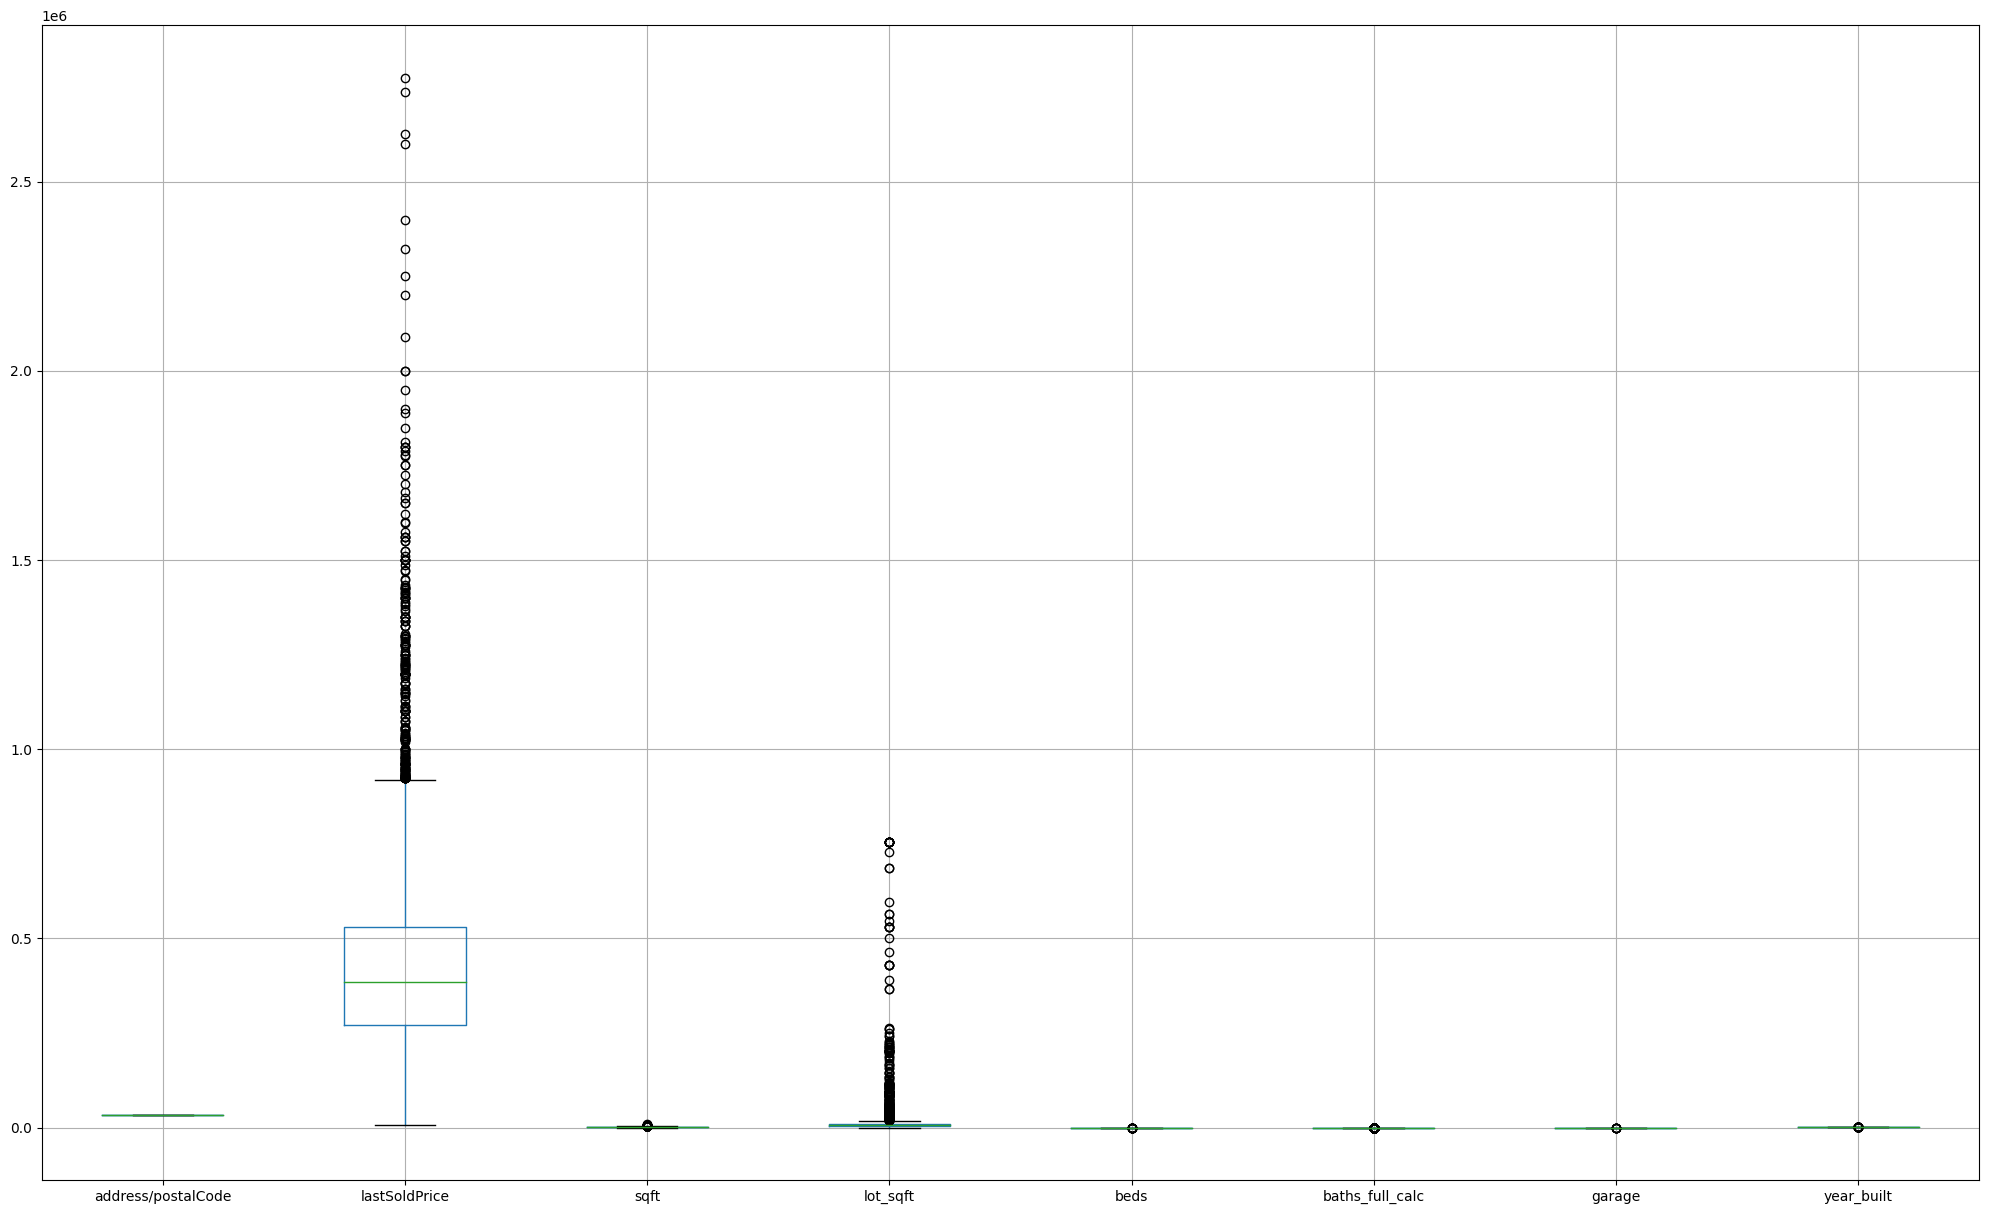

In [33]:
# check for outliers
plt.figure(figsize=(25,15))
df_clean.boxplot()

Now we don't have the huge outliers that were in LastSoldPrice, but there are still some there. Let's leave these for now since it looks like they are more condensed at lower areas and taper off more naturally. Also this is reflective of the data the model would actually encounter, where the vast majority of the houses will be below a million dollars, and there are fewer houses as the price point increases.

Let's look at some of the listings that are outliers for lot_sqft

In [34]:
print(df_clean[df_clean['lot_sqft'] > 500000])

      address/postalCode  lastSoldPrice           type    sqft  lot_sqft  \
191                32822         320000          condo  1544.0  727452.0   
243                32822         162000          condo   828.0  565844.0   
269                32822         166000          condo   629.0  565844.0   
283                32807         160000          condo   965.0  530561.0   
560                32822          75000          condo   900.0  756202.0   
858                32807         135000          condo   576.0  530561.0   
965                32807         150000          condo   853.0  530561.0   
997                32822         322500          condo  1699.0  687318.0   
1393               32822         325000          condo  1699.0  595465.0   
2080               32822          75000          condo   680.0  756202.0   
2328               32807         135150          condo   576.0  530561.0   
2443               32822          48000          condo   680.0  756202.0   
2455        

Most of these are condos, which doesn't make sense because most condos are either in a building and don't really have a "lot" and the lot size is way to big to be reasonable. Looking at some of the original listings it looks like the listed lot size is for the size of the whole condo complex.

Let's revisit this issue later when we look at correlations. If lotsize does not have a strong correlation with price, then we can just remove that feature during feature engineering and the outliers associated with the condos won't cause problems for the model. If the lot size does have a strong correlation with price then we can pivot and remove the condo listings from the model

As far as just dealing with outliers, let's look at a histogram of the lot_sqft to see what the threshold is for removing the upper outliers

(array([4.198e+03, 7.100e+01, 3.100e+01, 8.000e+00, 2.000e+00, 5.000e+00,
        2.000e+00, 8.000e+00, 0.000e+00, 1.300e+01]),
 array([1.110000e+02, 7.572010e+04, 1.513292e+05, 2.269383e+05,
        3.025474e+05, 3.781565e+05, 4.537656e+05, 5.293747e+05,
        6.049838e+05, 6.805929e+05, 7.562020e+05]),
 <BarContainer object of 10 artists>)

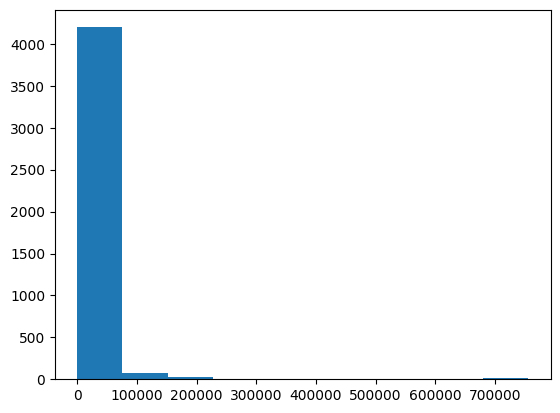

In [35]:
plt.hist(df_clean['lot_sqft'])

It looks like the large majority of properties are lots smaller than 100,000. Let's start by removing the above listings that were over 500,000 sqft, then more that are over 300,000 and take another look

In [36]:
df_clean = df_clean.drop([191,243,269,283,560,858,965,997,1393,2080,2328,2443,2455,2994,3168,3205,3341,3572,3592,3740,3768,4433])

In [37]:
print(df_clean[df_clean['lot_sqft'] > 300000])

      address/postalCode  lastSoldPrice   type    sqft  lot_sqft  beds  \
700                32807         225900  condo  1018.0  365904.0   2.0   
1178               32822         163000  condo  1118.0  429937.0   2.0   
1224               32822         170000  condo   825.0  429937.0   2.0   
1846               32839         180000  condo  1623.0  391169.0   3.0   
2615               32807         225000  condo  1294.0  365904.0   3.0   
3863               32822         115000  condo   860.0  429937.0   2.0   
4027               32822         240000  condo  1128.0  429937.0   2.0   
2729               32820         327000   land     0.0  463914.0   0.0   

      baths_full_calc  garage  year_built  
700               1.0     0.0      1978.0  
1178              2.0     0.0      1977.0  
1224              1.0     0.0      1977.0  
1846              2.0     0.0      1977.0  
2615              2.0     0.0      1978.0  
3863              1.0     0.0      1977.0  
4027              2.0    

In [38]:
df_clean = df_clean.drop([700,1178,1224,1846,2615,3863,4027,2729])

{'whiskers': [<matplotlib.lines.Line2D at 0x7a0c9e8ac0a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7a0c9e8ac5e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a0c9e87fdc0>],
 'medians': [<matplotlib.lines.Line2D at 0x7a0c9e8acb20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7a0c9e8acdc0>],
 'means': []}

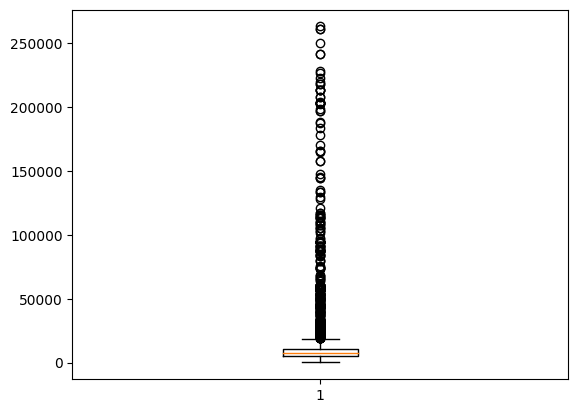

In [39]:
plt.boxplot(df_clean['lot_sqft'])

There are still a good number of higher outliers, so let's cut off some more, leaving only those below 125,000

In [40]:
print(df_clean[df_clean['lot_sqft'] > 150000])

      address/postalCode  lastSoldPrice           type    sqft  lot_sqft  \
185                32839         580000  single_family  2153.0  170320.0   
698                32822         205000          condo   820.0  213008.0   
724                32827         463815          condo  1486.0  165964.0   
1090               32822         180000          condo   820.0  261360.0   
1123               32822        1350000  single_family  1890.0  250034.0   
1760               32822         180000          condo  1030.0  241322.0   
2049               32822         215000          condo   820.0  203425.0   
2185               32822         190000          condo   820.0  213008.0   
2264               32822         208000          condo   820.0  213008.0   
2302               32818         460000         mobile  3055.0  204296.0   
2367               32832         717500  single_family  1973.0  219978.0   
2469               32832         815000  single_family  2292.0  217800.0   
2677        

In [41]:
df_clean = df_clean.drop([185,698,724,1090,1123,1760,2049,2185,2264,2302,2367,2469,2677,2817,2896,3039,3143,3213,3249,3381,3537,3694,3832,4096,4145,4162,4279,4593,4599,4614,4641,517,841,1104,1857,2081,2198,2648,3951])

In [42]:
print(df_clean[df_clean['lot_sqft'] > 125000])

      address/postalCode  lastSoldPrice           type    sqft  lot_sqft  \
1095               32836        1599000  single_family  1124.0  144619.0   
2364               32822         195000          condo  1090.0  133294.0   
2998               32805        1200000  single_family  3471.0  128066.0   
3396               32833         336000         mobile  2266.0  147668.0   
3765               32820        1200000  single_family  3427.0  145055.0   
4425               32822         248500          condo   995.0  133294.0   
4629               32808         400000  single_family  1363.0  135036.0   
462                32833         350000           land     0.0  144184.0   
1346               32817         350000           land     0.0  129809.0   

      beds  baths_full_calc  garage  year_built  
1095   1.0              1.0     0.0      1966.0  
2364   2.0              2.0     0.0      1984.0  
2998   3.0              4.0     2.0      1940.0  
3396   4.0              3.0     0.0    

In [43]:
df_clean = df_clean.drop([1095,2364,2998,3396,3765,4425,4629,462,1346])

{'whiskers': [<matplotlib.lines.Line2D at 0x7a0c9e8ff070>,
 'caps': [<matplotlib.lines.Line2D at 0x7a0c9e8ff5b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a0c9e8fedd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7a0c9e8ffaf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7a0c9e8ffd90>],
 'means': []}

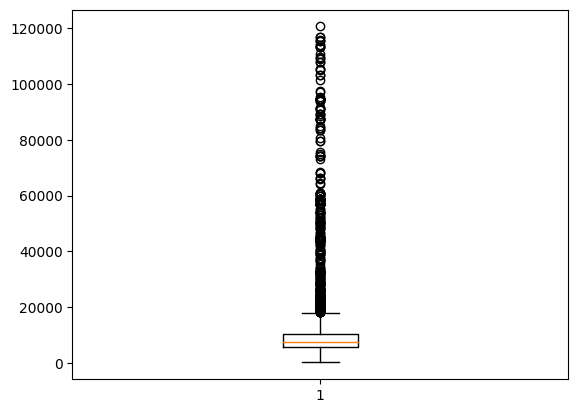

In [44]:
plt.boxplot(df_clean['lot_sqft'])

(array([3459.,  501.,   82.,   70.,   66.,   14.,   14.,   29.,   10.,
          15.]),
 array([1.11000e+02, 1.21660e+04, 2.42210e+04, 3.62760e+04, 4.83310e+04,
        6.03860e+04, 7.24410e+04, 8.44960e+04, 9.65510e+04, 1.08606e+05,
        1.20661e+05]),
 <BarContainer object of 10 artists>)

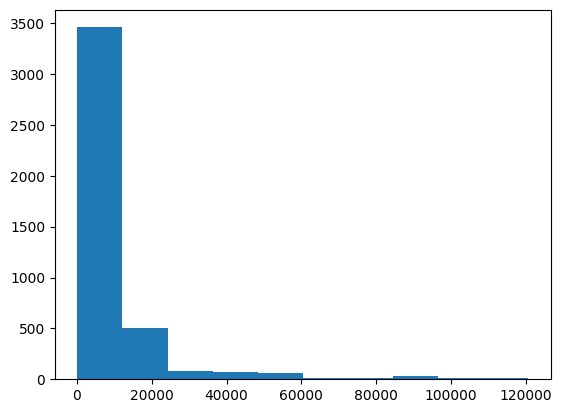

In [45]:
plt.hist(df_clean['lot_sqft'])

There are still outliers, but we are seeing more of a trailing tail than before. Let's stop here for now, and we can revisit if lot size is one of the features we move forward with for the model

Let's look closer at the boxplot for sqft

{'whiskers': [<matplotlib.lines.Line2D at 0x7a0c9e8059f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7a0c9e805f30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a0c9e805750>],
 'medians': [<matplotlib.lines.Line2D at 0x7a0c9e806470>],
 'fliers': [<matplotlib.lines.Line2D at 0x7a0c9e806710>],
 'means': []}

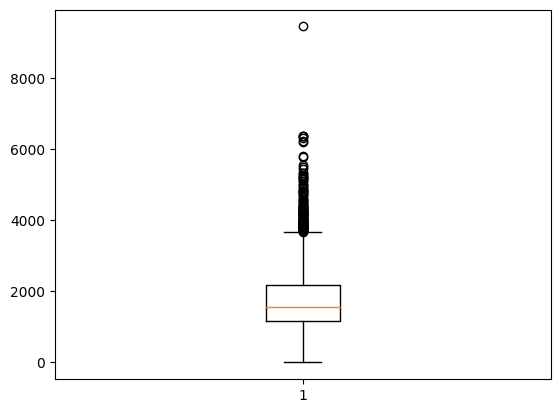

In [46]:
#check boxplot for sqft
plt.boxplot(df_clean['sqft'])


It looks like there is one listing that is way above the others, but the rest trail off similar to the LastSalePrice boxplot. Let's look at the highest values

In [47]:
print(df_clean[df_clean['sqft'] > 6000])

      address/postalCode  lastSoldPrice           type    sqft  lot_sqft  \
345                32821        1799000  single_family  6374.0    1052.0   
2278               32821        1811000  single_family  6330.0   11326.0   
2820               32821        1434750  single_family  6374.0    9487.0   
2922               32821        1415830  single_family  6374.0    9487.0   
3445               32821        1377910  single_family  9465.0    9465.0   
4334               32836        1250000  single_family  6224.0   10890.0   
4692               32836        1850000  single_family  6244.0   13068.0   

      beds  baths_full_calc  garage  year_built  
345   15.0             16.0     3.0      2023.0  
2278  15.0             15.0     2.0      2023.0  
2820  15.0             15.0     3.0      2023.0  
2922  15.0             15.0     3.0      2023.0  
3445  15.0             15.0     3.0      2023.0  
4334   5.0              4.0     3.0      2002.0  
4692   5.0              5.0     3.0      

It looks like the property that has the sqft over 9000 has a similar lot size and price to the other high listings and is in the same zipcode, but we will drop it because the sqft is so far above the others. The rest we will keep for now.

In [48]:
#drop the listing with sqft over 9000
df_clean = df_clean.drop([3445])

Lets check the unique values for beds to see if there are any errors or outliers

In [49]:
#check unique values for beds
df_clean['beds'].unique()


array([ 3.,  2.,  4.,  5.,  8., 10.,  1.,  6., 15., 12.,  7.,  9.,  0.])

(array([ 330.,  745., 2843.,  276.,   43.,    9.,    3.,    0.,    6.,
           4.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

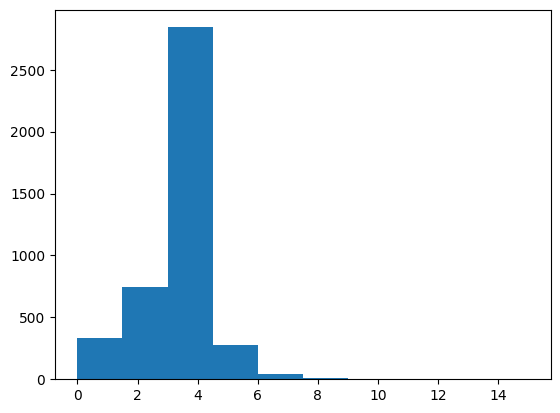

In [50]:
plt.hist(df_clean['beds'])

There are some properties that have a bunch of bedrooms. Looking at the histogram it looks like we should remove the listings with over 7 bedrooms

In [51]:
print(df_clean[df_clean['beds'] > 7])

      address/postalCode  lastSoldPrice           type    sqft  lot_sqft  \
64                 32811         793500   multi_family  3480.0   21780.0   
92                 32821        1680000  single_family  4232.0    4895.0   
345                32821        1799000  single_family  6374.0    1052.0   
661                32806         850000   multi_family  3572.0    8555.0   
1013               32821        1175520  single_family  3949.0    6512.0   
1882               32821        1128620  single_family  4232.0    6458.0   
2278               32821        1811000  single_family  6330.0   11326.0   
2645               32821        1160040  single_family  4842.0    6258.0   
2683               32821        1211250  single_family  4842.0    6007.0   
2820               32821        1434750  single_family  6374.0    9487.0   
2848               32806         795000   multi_family  3519.0   10454.0   
2878               32821        1139530  single_family  4842.0    6007.0   
2922        

In [52]:
# drop listinsg with more than 7 bedrooms

df_clean = df_clean.drop([64,92,345,661,1013,1882,2278,2645,2683,2820,2848,2878,2922,2979,3072,3374,3899,3940,4238,4375,4513,4587])

Let's do the same check for number of bathrooms

In [53]:
#check unique values for beds
df_clean['baths_full_calc'].unique()


array([2., 3., 1., 4., 5., 6., 0.])

(array([ 125.,  520.,    0., 2687.,    0.,  685.,  178.,    0.,   38.,
           4.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

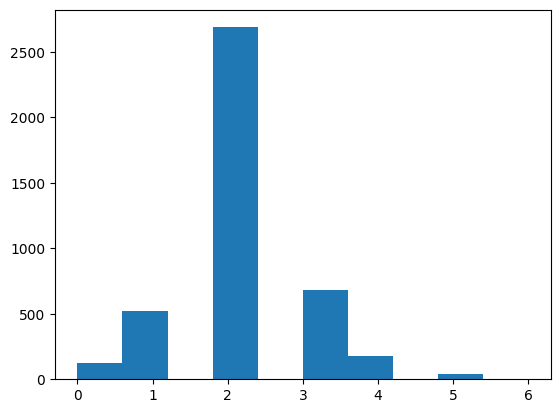

In [54]:
plt.hist(df_clean['baths_full_calc'])

In [55]:
print(df_clean[df_clean['baths_full_calc'] > 5])

      address/postalCode  lastSoldPrice           type    sqft  lot_sqft  \
1725               32836        1500000  single_family  5185.0   10454.0   
2162               32804        2323000  single_family  5788.0   14375.0   
2807               32836        1250000  single_family  5294.0   10890.0   
4083               32821        1059480  single_family  2913.0    7559.0   

      beds  baths_full_calc  garage  year_built  
1725   6.0              6.0     3.0      2014.0  
2162   6.0              6.0     2.0      1936.0  
2807   6.0              6.0     3.0      2014.0  
4083   6.0              6.0     2.0      2023.0  


There are only a few properties with more than 5 bathrooms, and the distribution looks like it slopes off gradually like many of the other features we can leave these in for now.

Let's look at the values for garages

In [56]:
df_clean['garage'].unique()

array([ 2.,  0.,  1.,  3.,  4.,  6.,  7.,  8., 15.,  5.])

{'whiskers': [<matplotlib.lines.Line2D at 0x7a0c9e589ab0>,
 'caps': [<matplotlib.lines.Line2D at 0x7a0c9e58a020>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a0c9e589810>],
 'medians': [<matplotlib.lines.Line2D at 0x7a0c9e58a560>],
 'fliers': [<matplotlib.lines.Line2D at 0x7a0c9e58a800>],
 'means': []}

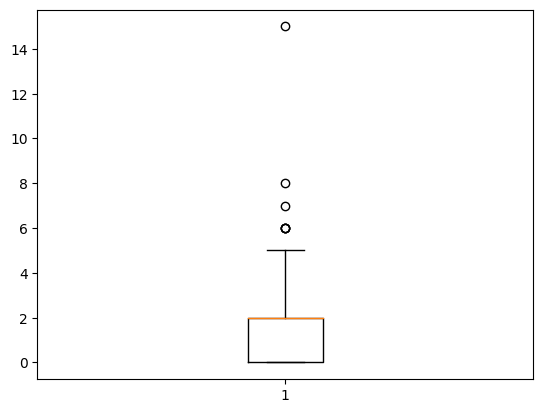

In [57]:
plt.boxplot(df_clean['garage'])

It looks like there are a really minimal number of listings with more than 5 garage spaces, so let's remove those outliers

In [58]:
print(df_clean[df_clean['garage'] > 5])

      address/postalCode  lastSoldPrice           type    sqft  lot_sqft  \
911                32832         790000  single_family  3950.0    7405.0   
929                32837         760000  single_family  3149.0   27000.0   
1608               32819         475000  single_family  2074.0   12632.0   
2791               32833         475000  single_family  1883.0   10019.0   
3210               32818         202000  single_family   936.0   20038.0   
3291               32809        1240000  single_family  4239.0   23452.0   
3930               32822         308900   multi_family  1406.0    4621.0   

      beds  baths_full_calc  garage  year_built  
911    5.0              4.0     6.0      2018.0  
929    5.0              3.0     6.0      2016.0  
1608   3.0              2.0     7.0      1985.0  
2791   4.0              3.0     6.0      2018.0  
3210   2.0              2.0     6.0      1981.0  
3291   5.0              4.0     8.0      2001.0  
3930   3.0              2.0    15.0      

In [59]:
df_clean = df_clean.drop([911,929,1608,2791,3210,3291,3930])

The last thing we want to do is change the property types into numbers instead of objects, so we can calculate correlation and potentially include them in the models

In [60]:
df_clean['type'].value_counts()

type
single_family    2811
condo             767
townhomes         393
land              125
multi_family       98
mobile             36
Name: count, dtype: int64

In [61]:
df_clean = df_clean.replace(to_replace=r'single_family', value = 0, regex = True)
df_clean = df_clean.replace(to_replace=r'condo', value = 1, regex = True)
df_clean = df_clean.replace(to_replace=r'townhomes', value = 2, regex = True)
df_clean = df_clean.replace(to_replace=r'land', value = 3, regex = True)
df_clean = df_clean.replace(to_replace=r'multi_family', value = 4, regex = True)
df_clean = df_clean.replace(to_replace=r'mobile', value = 5, regex = True)

df_clean['type'].value_counts()

type
0    2811
1     767
2     393
3     125
4      98
5      36
Name: count, dtype: int64

Let's look at the distribution for the various features in histograms now that we have removed a bunch of outliers

array([[<Axes: title={'center': 'address/postalCode'}>,
        <Axes: title={'center': 'lastSoldPrice'}>,
        <Axes: title={'center': 'type'}>],
       [<Axes: title={'center': 'sqft'}>,
        <Axes: title={'center': 'lot_sqft'}>,
        <Axes: title={'center': 'beds'}>],
       [<Axes: title={'center': 'baths_full_calc'}>,
        <Axes: title={'center': 'garage'}>,
        <Axes: title={'center': 'year_built'}>]], dtype=object)

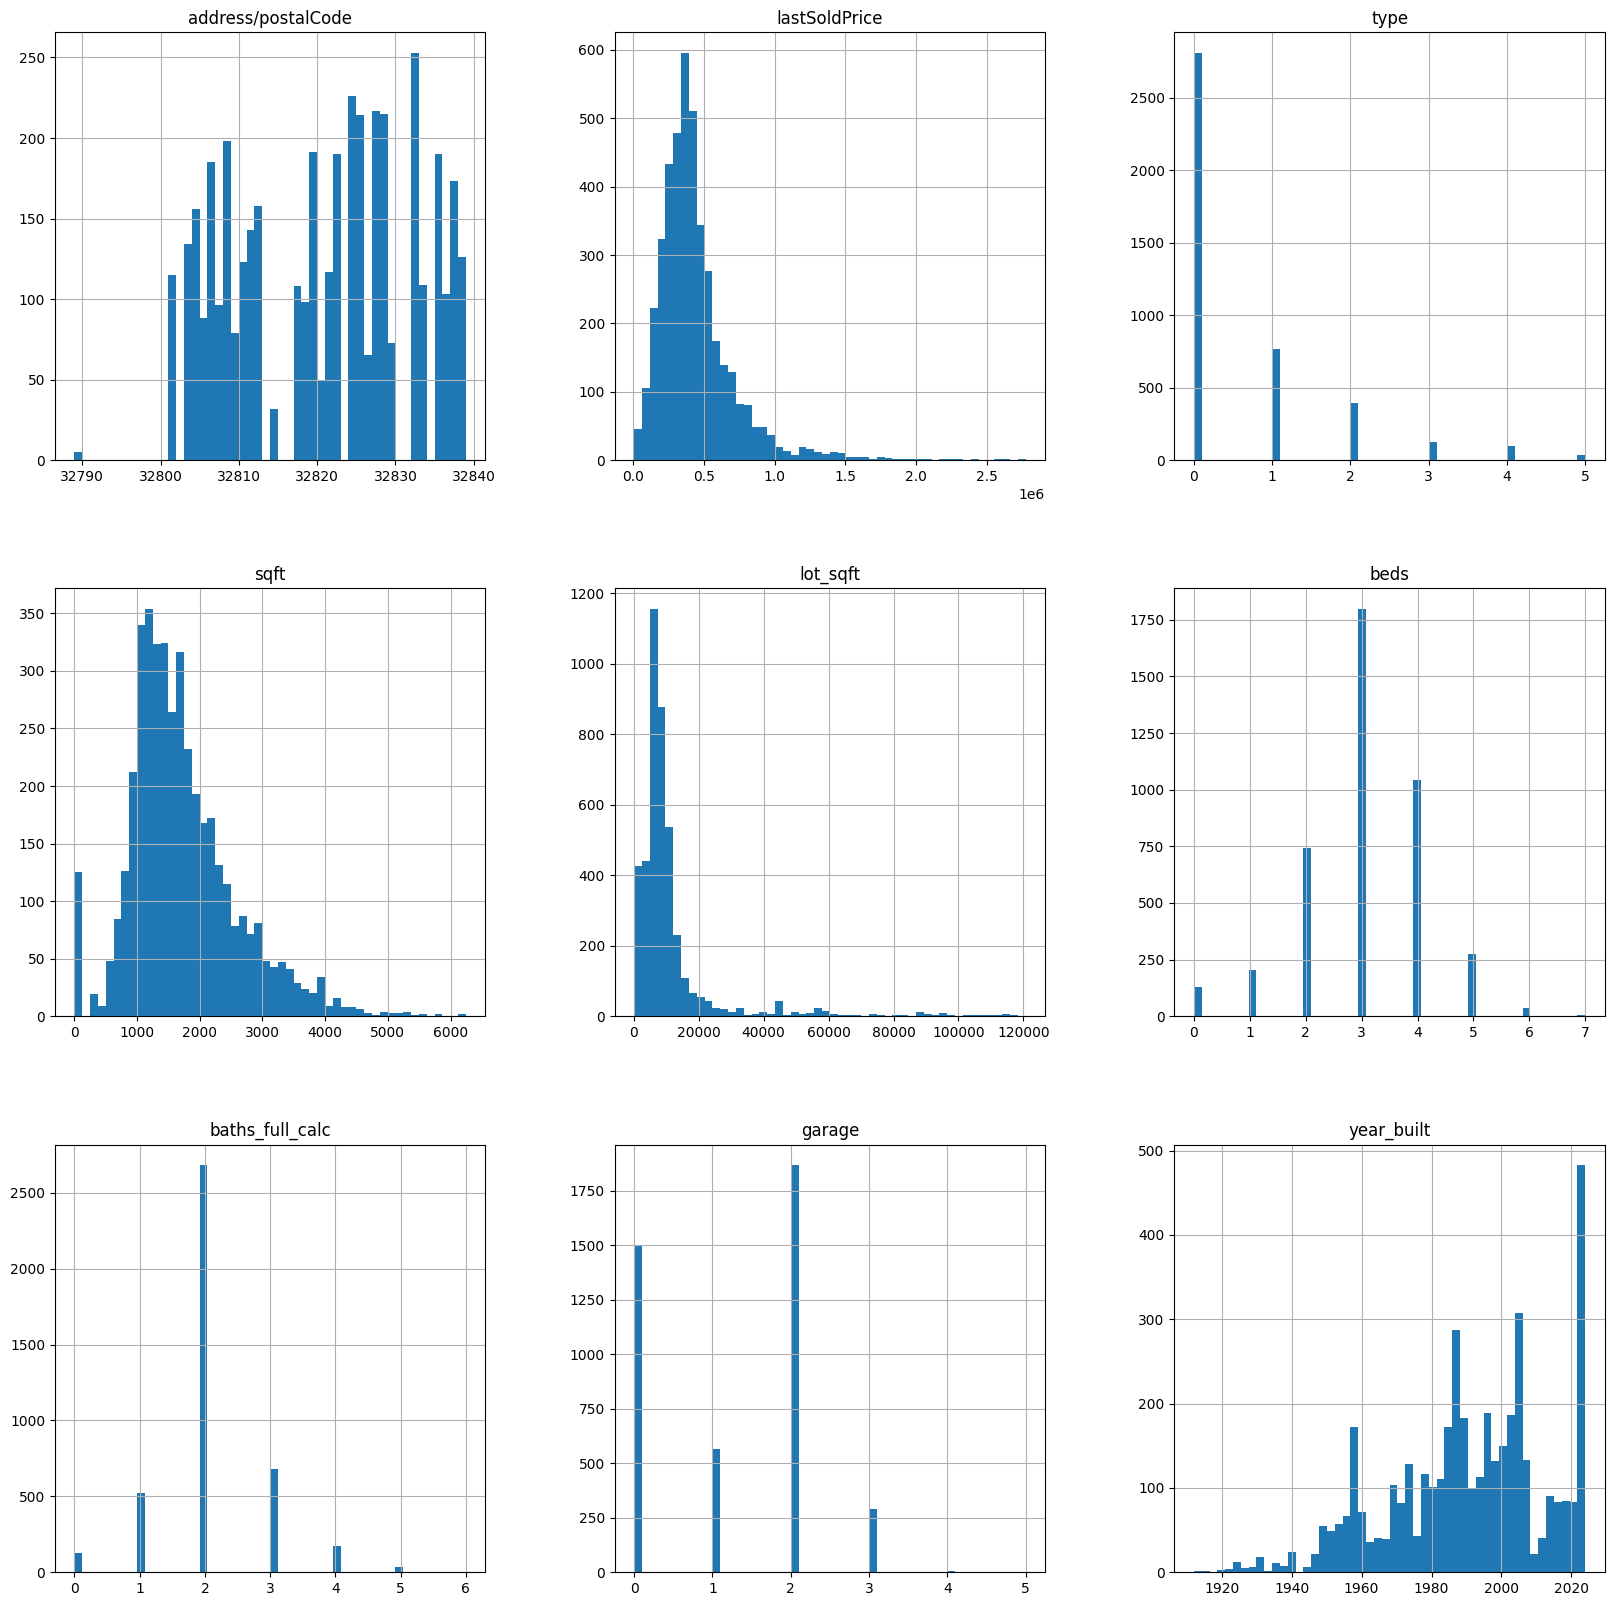

In [62]:
df_clean.hist(bins=50, figsize=(20,20))

We can ignore the postal code distribution for the most part.

While the list price is pretty skewed, it does reflect the reality of the data that the model would be encountering, with the vast majority of houses being priced at less than a million dollars and an average around 400,000 dollars.

We see similar trends in square footage, which is expected because it would make sense that the majority of houses being less expensive would mean a majority of houses are smaller, and the small number of houses that cost more than a million dollars would mean a smaller number of houses that have large square footage.

For type, the most common type is single family homes, then condos and townhouses, with mobile homes being the least common property type.

For lot square feet, most of the properties are less than 200,000 sqft (about 4.5 acres) and there are a small number that are larger porperties.

The number of beds and baths look to be approximately normally distributed, which makes sense as the most common house size is 3-4 beds and 2 baths.

For year_built, we would expect to see a greater number of houses in more recent years as a result of significant population expansion in Orlando since 1950, leading to more houses and developments being built to accomodate a growing population, and more common demolition of older houses to build newer bigger houses.



Let'a make a scatter plot of the different features to see how they interact before we move forward

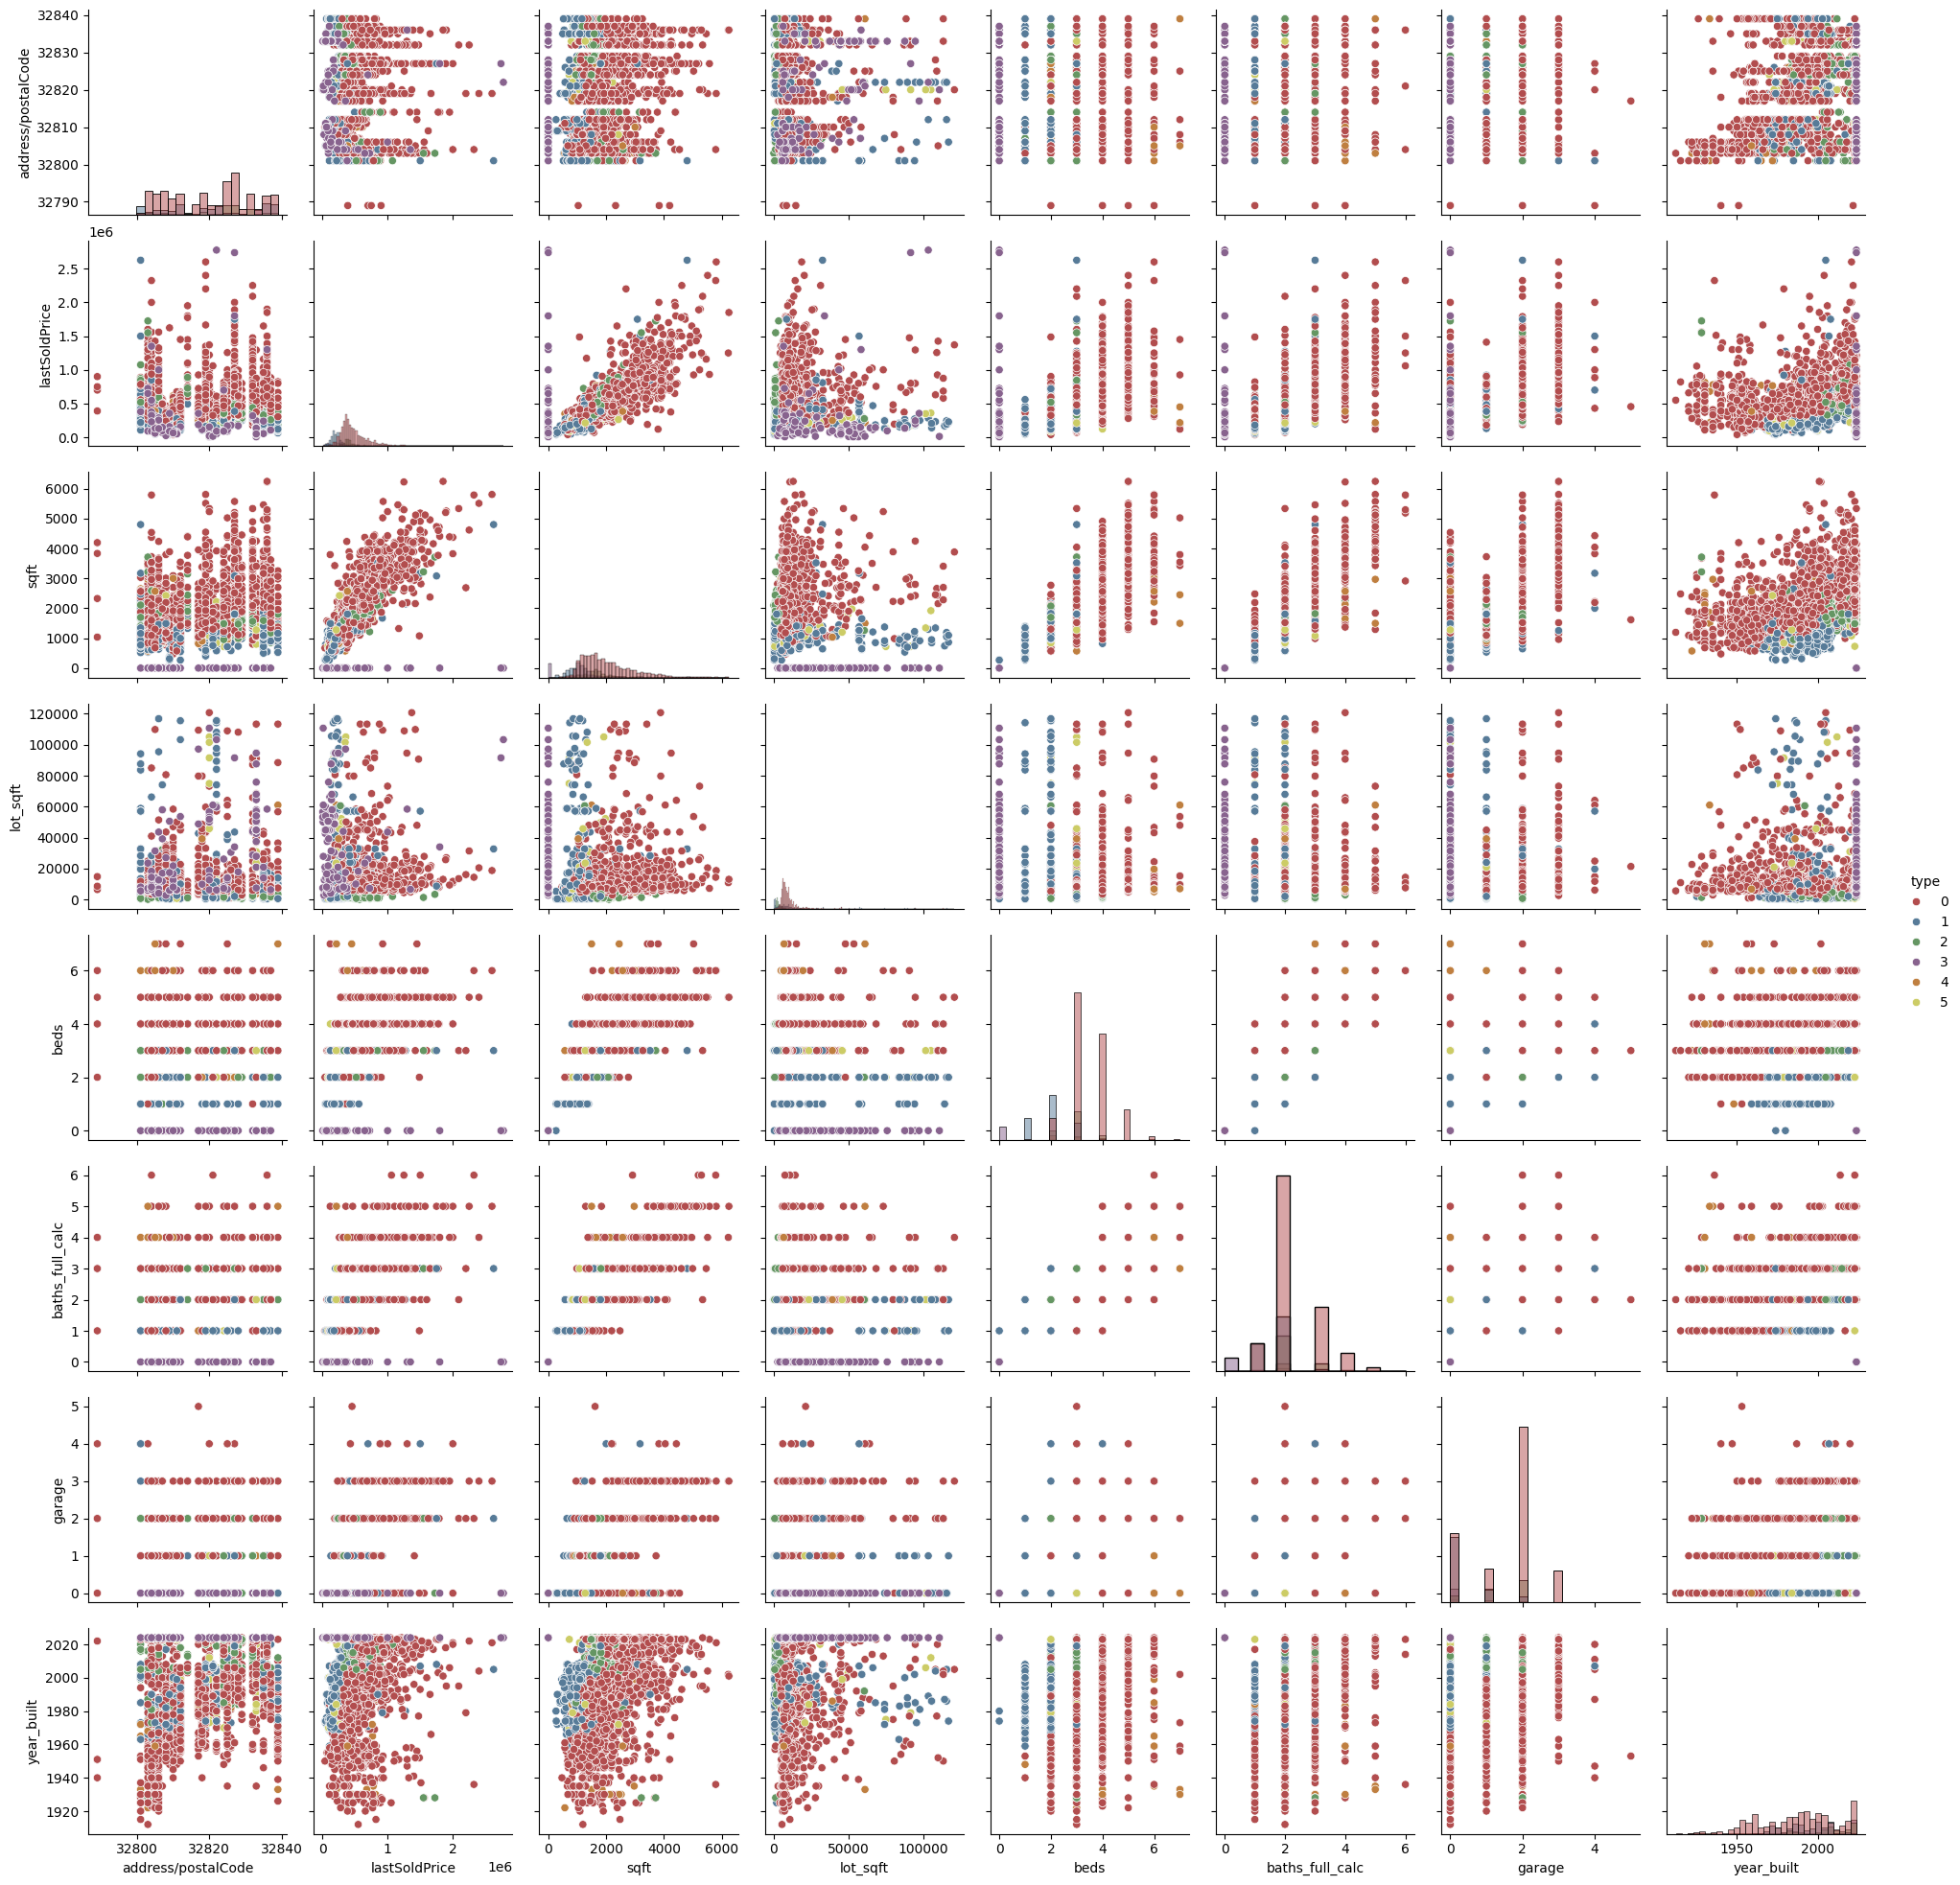

In [63]:
_ = sns.pairplot(
    data = df_clean,
    kind="scatter",
    hue="type",
    diag_kind="hist",
    palette=sns.color_palette("Set1", desat=.5),
)

Based on the scatter plots, there are a few features that seem more correlated with the sale price, such as square footage. One things that I noticed in looking at the scatter plots is that the listings for land type properties aren't following the same trends as the other properties in many of the features, which could create a problem for the model. Let's drop the properties that are just land.

In [64]:
# remove any listings with value 3 (the value we assigned for 'land)
df_clean = df_clean.drop(df_clean[df_clean['type'] == 3].index)

# check that it worked
df_clean['type'].value_counts()

type
0    2811
1     767
2     393
4      98
5      36
Name: count, dtype: int64

# Local Model: Feature Engineering

In [128]:
#save the cleaned dataframe with outliers and errors removed to a new dataframe that will be what we use for our feature engineering and model building
df_final = df_clean

Let's get a look at the correlation of the various features

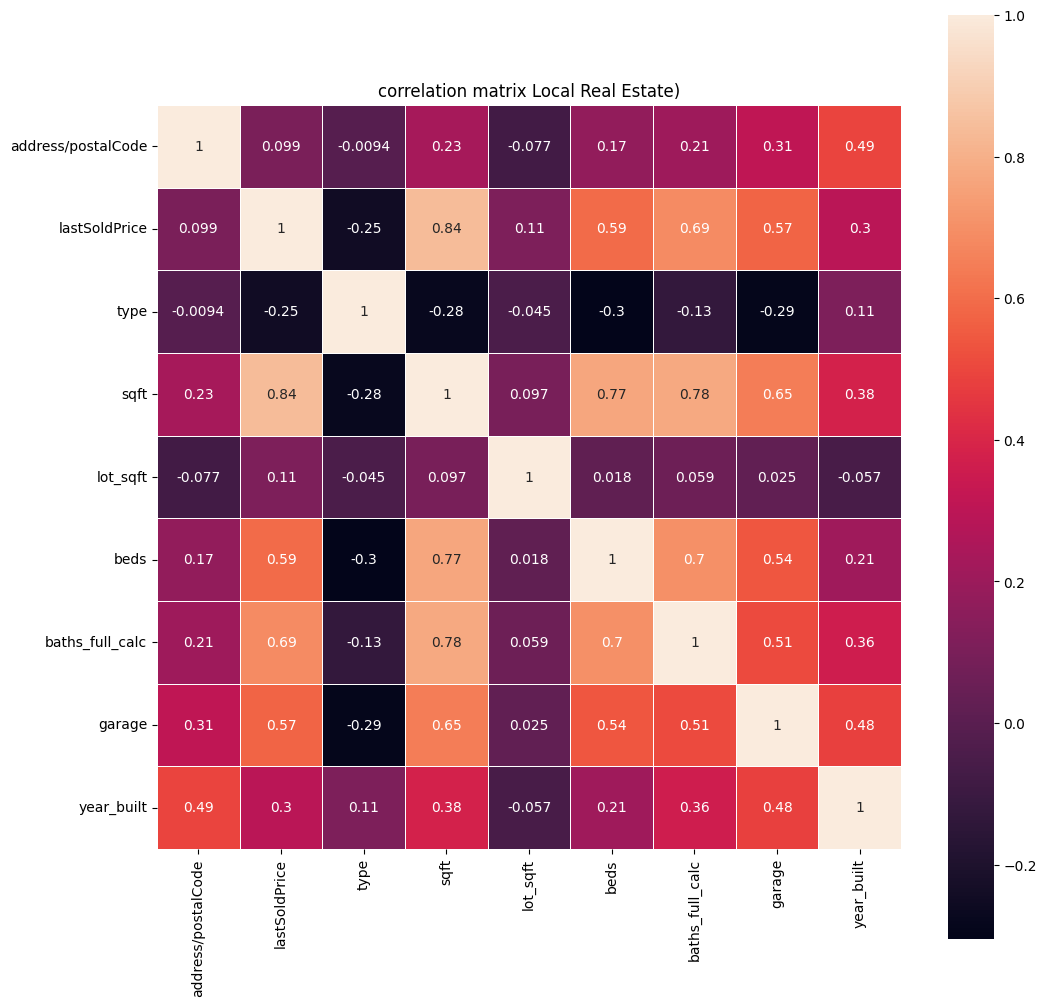

In [129]:

# Make the correlation matrices
corrmat_local = df_final.corr()

#resize the figure
plt.figure(figsize=(12,12))

#draw a heatmap for the data
sns.heatmap(corrmat_local, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix Local Real Estate)")


plt.show()

Looking at the correlation matrix, it looks like the features that are most highly correlated with the 'lastSoldPrice' feature are sqft (84%), full baths (69%), beds (59%), garage (57%), and log_sqft (78%).

Looking at correlations between the other variables, beds and baths are both pretty highly correlated with square feet and each other (which makes sense, as larger houses usually have more beds/baths, and more beds usually means more people and requires mnomre bathrooms). So we might be able to use sqft to represent the other two variables that are highly correlated with it.

We also see that the garage size is fairly well correlated with the sqft (bigger houses usually have more cars and need a bigger garage)

Lastly we see that postal code and year built are somewhat correlated, which makes sense because as the city expands, certain neighborhoods have increases in new builds while already developed neighborhoods see fewer new builds


In [130]:
# drop features with low correlation

df_final = df_final.drop(['address/postalCode', 'lot_sqft', 'type'], axis = 1)

df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4105 entries, 0 to 4786
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lastSoldPrice    4105 non-null   int64  
 1   sqft             4105 non-null   float64
 2   beds             4105 non-null   float64
 3   baths_full_calc  4105 non-null   float64
 4   garage           4105 non-null   float64
 5   year_built       4105 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 224.5 KB


Let's make combinations of some of the variables and then look at their correlations with the rest of the variables

In [131]:
# beds per log_sqft
df_final['bed_per_sqft'] = df_final['beds'] * df_final['sqft']

# baths per log_sqft
df_final['baths_per_sqft'] = df_final['baths_full_calc'] * df_final['sqft']

Let's make the correlation matrix again and see if there is any strong correlation with the new variables

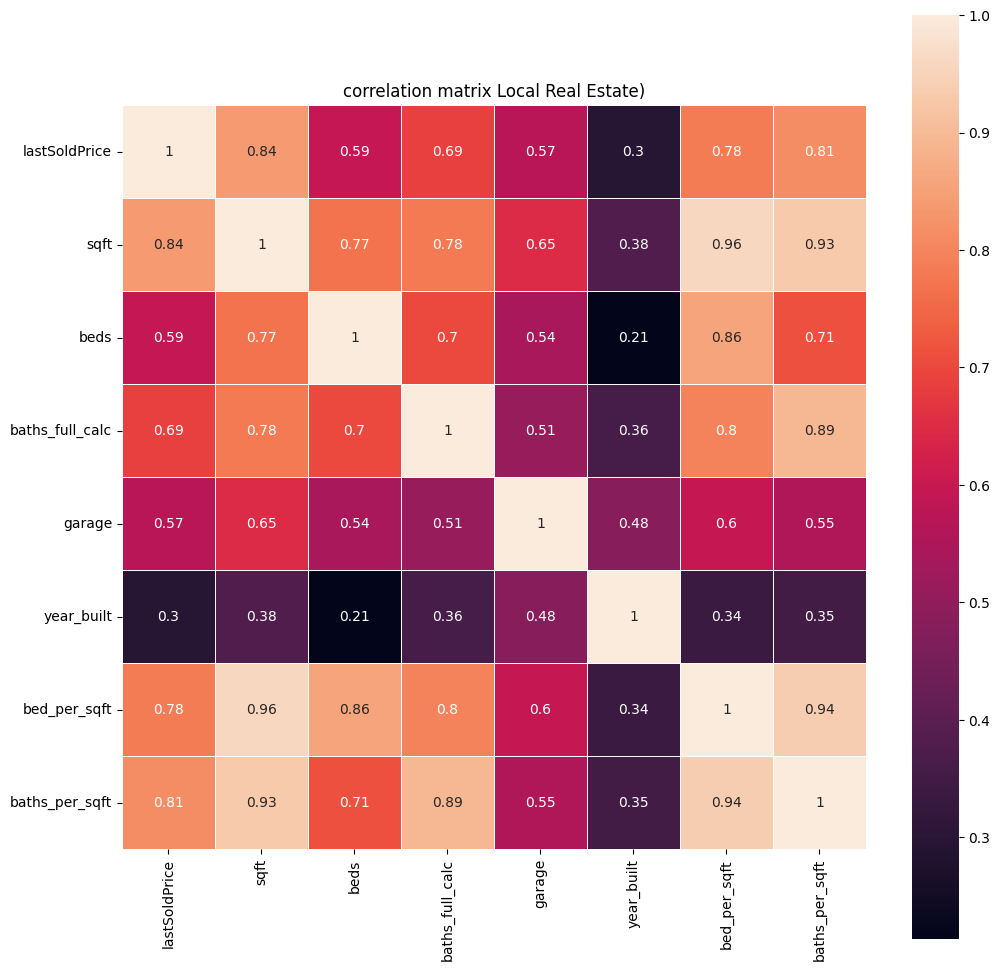

In [132]:
# Make the correlation matrices
corrmat_local = df_final.corr()

#resize the figure
plt.figure(figsize=(12,12))

#draw a heatmap for the data
sns.heatmap(corrmat_local, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix Local Real Estate)")


plt.show()

The new variables we made have good correlations with the price feature, and higher correlations with it than the original beds and baths features. So let's try using these in our model building.

We also see that year_built is pretty low compared to other variables, but this could be useful for explaining the difference in price between two houses that otherwise have the same features.

# Local Model: Basic version

Before starting to build complex models, I want to build a very simple linear regression model to use as a baseline for comparing other models to. For this model, I will use just the non-transformed most highly correlated feature (sqft) to determine price using the non-transformed lastSoldPrice.

In [133]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

import warnings
warnings.filterwarnings('ignore')

In [134]:
# set your target variables and explanatory variables

# `Y` is the target variable (what you are trying to predict)
y = df_final['lastSoldPrice']

# `X` is the feature set that you are using to predict the medical costs
X = df_final['sqft']

In [135]:
#split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = .8)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 3284
The number of observations in test set is 821


In [136]:
# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print the summary results
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:          lastSoldPrice   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                          3.886e+04
Date:                Thu, 04 Apr 2024   Prob (F-statistic):                        0.00
Time:                        19:37:05   Log-Likelihood:                         -43708.
No. Observations:                3284   AIC:                                  8.742e+04
Df Residuals:                    3283   BIC:                                  8.742e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Now let's plot the predictions compared to the true values

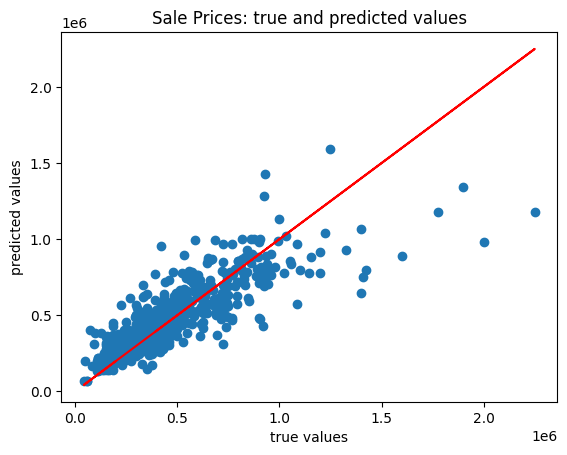

In [137]:
# Make predictions
y_preds = results.predict(X_test)

# Make a scatter plot of the true vs predicted values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sale Prices: true and predicted values")
plt.show()


In [138]:
print("-----Test set statistics-----")
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

-----Test set statistics-----
Mean absolute error of the prediction is: 90406.33822211971
Mean squared error of the prediction is: 19573887289.649136
Root mean squared error of the prediction is: 139906.70923743842
Mean absolute percentage error of the prediction is: 24.043434237871153


The model looks like it performs better on the lower end of the values, as the data gets more spread out towards the upper end of the range. The data looks like it might follow a more logarithmic curve, with the slope decreasing as the true values get higher

This basic model scored fairly well considering it used only a single feature.

The R-squared value is very close to 1 (0.92),	meaning that 92 % of the variation in the y values is accounted for by the x values. This sounds really good, but looking at the graph we can see that while most of the values form a straight line, there is still a wide variation around the line that seems to average itself out.

Mean absolute error (MAE) represents the average of the absolute difference between the actual and predicted values in the dataset. The score for this was 90,406.34. This means that, on average, there was a difference of 90,406.34 dollars between the predicted and actual values, which is pretty high when the average house price in the data is around 400,000.

Mean squared error (MSE) represents the average of the squared difference between the original and predicted values in the data set. This model scored extremely high, which makes sense when the MAE was also pretty high.

Root mean squared error (RMSE) provides an estimation of how well the model is able to predict the target value (accuracy). The lower the value of the Root Mean Squared Error, the better the model is. A perfect model (a hypothetic model that would always predict the exact expected value) would have a Root Mean Squared Error value of 0. This model had a pretty high RMSE score (139906), and since RMSE can be interpreted as the amount of error in dollars, we can say that the error root mean squared error is about 140,000 dollars (which is a pretty big error when we are mostly predicting prices below 1 million dollars


# Local Model: Model 1 (Lasso Regression - V1)

For the first model I wanted to use Lasso Regression because ______________________________

Lasso Regression:
The Lasso is a linear model that estimates sparse coefficients with l1 regularization.



In [175]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

# set info for alphas
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [176]:
# set your target variables and explanatory variables

# `Y` is the target variable (what you are trying to predict)
y = df_final['lastSoldPrice']

# `X` is the feature set that you are using to predict the medical costs
X = df_final[['sqft', 'beds', 'baths_full_calc', 'garage', 'bed_per_sqft', 'baths_per_sqft', 'year_built']]

In [177]:
#split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = .8)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 3284
The number of observations in test set is 821


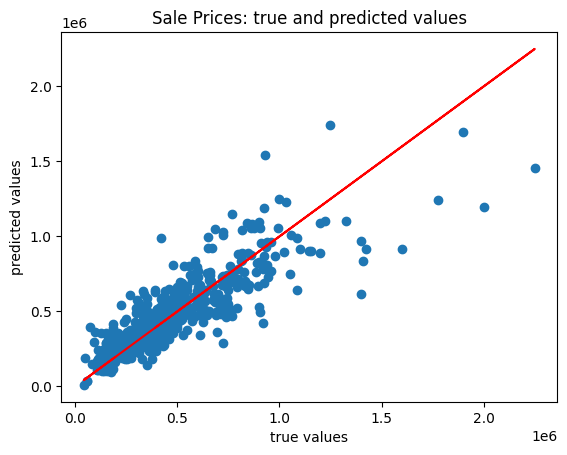

Best alpha value is: 10.0
R-squared of the model in training set is: 0.7408892291602873
-----Test set statistics-----
R-squared of the model in test set is: 0.7371981079168641
Mean absolute error of the prediction is: 84520.57499549283
Mean squared error of the prediction is: 16688967961.097763
Root mean squared error of the prediction is: 129185.78854153333
Mean absolute percentage error of the prediction is: 22.23724884782664


In [178]:
# Try using Lasso Regression

#perform cross validation to find the best value for alpha
lasso_cv = LassoCV(alphas=alphas, cv=5)

# fit the model
lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds = lasso_cv.predict(X_test)

# Make a scatter plot of the true vs predicted values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sale Prices: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

# Local Model: Model 1 (Lasso Regression - V2)

For the second version of this model I will drop the least correlated variable ('year_built') and see if the model performs better



In [200]:
# set your target variables and explanatory variables

# `Y` is the target variable (what you are trying to predict)
y = df_final['lastSoldPrice']

# `X` is the feature set that you are using to predict the medical costs
X = df_final[['sqft', 'beds', 'baths_full_calc','bed_per_sqft', 'baths_per_sqft', 'garage']]

In [201]:
#split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = .8)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 3284
The number of observations in test set is 821


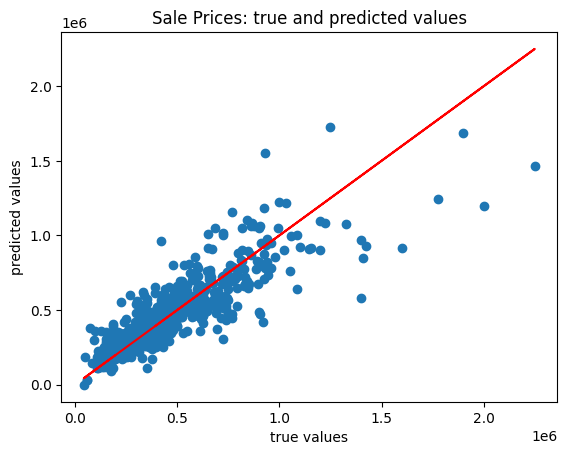

Best alpha value is: 10.0
R-squared of the model in training set is: 0.7390246851824521
-----Test set statistics-----
R-squared of the model in test set is: 0.7351388013227929
Mean absolute error of the prediction is: 84829.2240472659
Mean squared error of the prediction is: 16819742140.454357
Root mean squared error of the prediction is: 129690.94856794886
Mean absolute percentage error of the prediction is: 22.287408701520707


In [202]:

# fit the model
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds = lasso_cv.predict(X_test)

# Make a scatter plot of the true vs predicted values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sale Prices: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

This model had a slightly better R-squared, but the other statstical values are igher than the first version of the model.

# Local Model: Model 1 (Lasso Regression - V3)

For the third version of this model I will remove the next least correlated variable 'garage'

In [203]:
# set your target variables and explanatory variables

# `Y` is the target variable (what you are trying to predict)
y = df_final['lastSoldPrice']

# `X` is the feature set that you are using to predict the medical costs
X = df_final[['sqft', 'beds', 'baths_full_calc','bed_per_sqft', 'baths_per_sqft']]

In [204]:
#split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = .8)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 3284
The number of observations in test set is 821


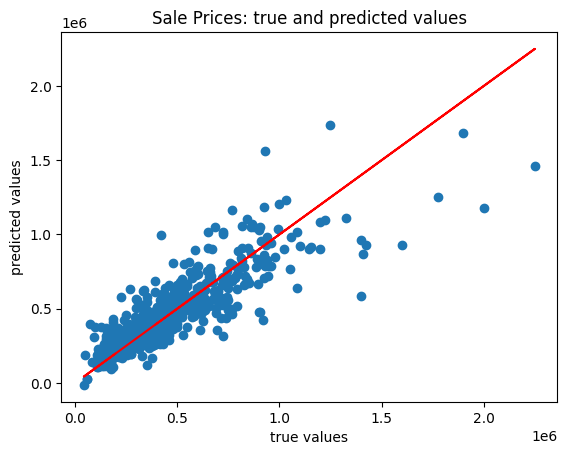

Best alpha value is: 10.0
R-squared of the model in training set is: 0.7372583169336846
-----Test set statistics-----
R-squared of the model in test set is: 0.7290197310261743
Mean absolute error of the prediction is: 86176.84642224445
Mean squared error of the prediction is: 17208327501.550873
Root mean squared error of the prediction is: 131180.51494620257
Mean absolute percentage error of the prediction is: 23.05022454039633


In [205]:

# fit the model
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds = lasso_cv.predict(X_test)

# Make a scatter plot of the true vs predicted values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sale Prices: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

This version of the model has a lower r-squared value, and also has a higher mean absolute error, meaning tha the difference between the true values and predicted values is greater than the previous version of the model.

It looks like the best version of the Lasso Regression model is the first one that used all of the features, though looking at the MAE value, having an 84,500 dollar difference between the predicted and true prices is pretty large.

# Local Model: Model 2 (Elastic Net Regression - V1)

ElasticNet:
Elastic-Net is a linear regression model trained with both l1 and l2 -norm regularization of the coefficients.


In [188]:
# set your target variables and explanatory variables

# `Y` is the target variable (what you are trying to predict)
y = df_final['lastSoldPrice']

# `X` is the feature set that you are using to predict the medical costs
X = df_final[['sqft', 'beds', 'baths_full_calc', 'garage', 'bed_per_sqft', 'baths_per_sqft', 'year_built']]

In [189]:
#split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = .8)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 3284
The number of observations in test set is 821


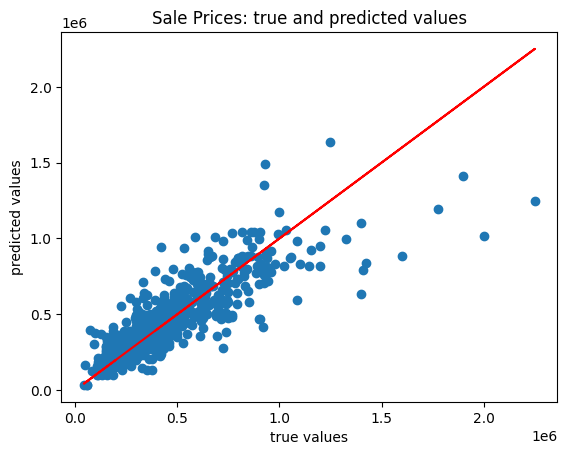

Best alpha value is: 0.01
R-squared of the model in training set is: 0.7408351543621077
-----Test set statistics-----
R-squared of the model in test set is: 0.7371471010462104
Mean absolute error of the prediction is: 84484.37200351321
Mean squared error of the prediction is: 16692207100.753069
Root mean squared error of the prediction is: 129198.32468245503
Mean absolute percentage error of the prediction is: 22.18307492324839


In [190]:
# Try using Elastic Net Regression

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

# Make a scatter plot of the true vs predicted values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sale Prices: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

This model perfomed about the same as the first version of the linear regression model, but still far below the scores for the basic model. Let's try removing features and running it again to see if we can improve.

# Local Model: Model 2 (Elastic Net Regression - V2)

Removed the garage feature to see how that affects the model

In [191]:
# set your target variables and explanatory variables

# `Y` is the target variable (what you are trying to predict)
y = df_final['lastSoldPrice']

# `X` is the feature set that you are using to predict the medical costs
X = df_final[['sqft', 'beds', 'baths_full_calc', 'bed_per_sqft', 'baths_per_sqft', 'year_built']]

In [192]:
#split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = .8)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 3284
The number of observations in test set is 821


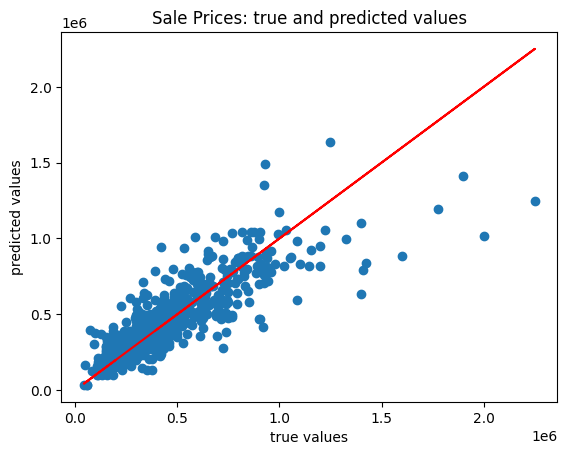

Best alpha value is: 0.01
R-squared of the model in training set is: 0.7378681833167087
-----Test set statistics-----
R-squared of the model in test set is: 0.7289070338837751
Mean absolute error of the prediction is: 86138.45909825135
Mean squared error of the prediction is: 17215484219.426453
Root mean squared error of the prediction is: 131207.79023909537
Mean absolute percentage error of the prediction is: 23.098628744725577


In [193]:
# Try using Elastic Net Regression

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

# Make a scatter plot of the true vs predicted values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sale Prices: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

This version of the model did not perform as well as the one with all of the final features. Let's try removing a different feature and seeing if that improves anything.

# Local Model: Model 2 (Elastic Net Regression - V3)

Removed the year_built feature and added back the garage feature to see how that affects the model

In [207]:
# set your target variables and explanatory variables

# `Y` is the target variable (what you are trying to predict)
y = df_final['lastSoldPrice']

# `X` is the feature set that you are using to predict the medical costs
X = df_final[['sqft', 'garage' ,'beds', 'baths_full_calc', 'bed_per_sqft', 'baths_per_sqft']]

In [208]:
#split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = .8)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 3284
The number of observations in test set is 821


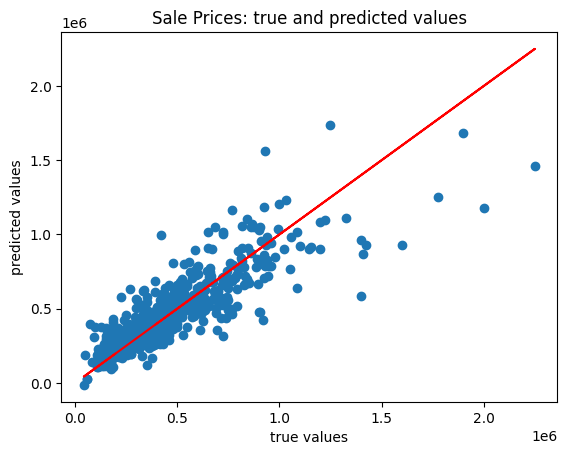

Best alpha value is: 0.001
R-squared of the model in training set is: 0.7390238696270297
-----Test set statistics-----
R-squared of the model in test set is: 0.7351420673410021
Mean absolute error of the prediction is: 84824.50374600271
Mean squared error of the prediction is: 16819534735.276178
Root mean squared error of the prediction is: 129690.14895232474
Mean absolute percentage error of the prediction is: 22.280893873287155


In [209]:
# Try using Elastic Net Regression

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

# Make a scatter plot of the true vs predicted values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sale Prices: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

This model had a better MAE value compared to the previous one, but not quite as good as the first version that used all of the features

# Local Model: Model Comparison

# Regional Model: Data Cleaning

In [161]:
#import dataset
df = pd.read_csv('/content/drive/MyDrive/kaggle/Realtor-Data-CtrlFL-sold.csv')

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6606 entries, 0 to 6605
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address/locality    6605 non-null   object 
 1   address/postalCode  6606 non-null   int64  
 2   address/region      6606 non-null   object 
 3   address/street      6587 non-null   object 
 4   lastSoldPrice       6606 non-null   int64  
 5   type                6606 non-null   object 
 6   sqft                6216 non-null   float64
 7   lot_sqft            5984 non-null   float64
 8   beds                6272 non-null   float64
 9   baths_full          6267 non-null   float64
 10  baths_half          1338 non-null   float64
 11  garage              4453 non-null   float64
 12  year_built          6252 non-null   float64
dtypes: float64(7), int64(2), object(4)
memory usage: 671.0+ KB


In [163]:
df.head()

,address/locality,address/postalCode,address/region,address/street,lastSoldPrice,type,sqft,lot_sqft,beds,baths_full,baths_half,garage,year_built
0,Longboat Key,34228,FL,4835 Gulf of Mexico Dr Apt 103,1150000,condos,1393.0,67518.0,2.0,2.0,NaN,NaN,1970.0
1,Davenport,33897,FL,353 Caribbean Dr # 110,265000,townhomes,1520.0,832.0,3.0,3.0,NaN,NaN,2002.0
2,Holly Hill,32117,FL,219 5th St,185000,single_family,1379.0,6880.0,3.0,1.0,1.0,1.0,1948.0
3,Mascotte,34753,FL,15906 Douglas Rd,170000,single_family,925.0,7590.0,3.0,1.0,NaN,NaN,1974.0
4,Poinciana,34759,FL,4091 Via Toledo Ct,714999,single_family,2325.0,7475.0,3.0,3.0,NaN,2.0,2022.0


For this model we will kepp the 'address/locality' column since they won't all be the same, but we can still drop the state since those will all be the same. We can also drop the 'address/street' info

In [164]:
# drop address/region and address/street
df = df.drop(['address/region', 'address/street'], axis=1)

Like we did for the local model, let's start by filling in some of the null values that are actually zeros.

In [165]:
# replace null values for garage, beds, and baths with 0
df["garage"].fillna(0, inplace=True)
df["beds"].fillna(0, inplace=True)
df["baths_full"].fillna(0, inplace=True)

# replace null values for year_built with 2024 (assuming that the nulls are for unbuilt properties that would hypothetically be built this year)
df["year_built"].fillna(2024, inplace=True)

In [166]:
# check dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6606 entries, 0 to 6605
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address/locality    6605 non-null   object 
 1   address/postalCode  6606 non-null   int64  
 2   lastSoldPrice       6606 non-null   int64  
 3   type                6606 non-null   object 
 4   sqft                6216 non-null   float64
 5   lot_sqft            5984 non-null   float64
 6   beds                6606 non-null   float64
 7   baths_full          6606 non-null   float64
 8   baths_half          1338 non-null   float64
 9   garage              6606 non-null   float64
 10  year_built          6606 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 567.8+ KB


We can also drop the feature for baths_half, since that was not a feature included in the local model data

In [167]:
df = df.drop(['baths_half'], axis = 1)

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6606 entries, 0 to 6605
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address/locality    6605 non-null   object 
 1   address/postalCode  6606 non-null   int64  
 2   lastSoldPrice       6606 non-null   int64  
 3   type                6606 non-null   object 
 4   sqft                6216 non-null   float64
 5   lot_sqft            5984 non-null   float64
 6   beds                6606 non-null   float64
 7   baths_full          6606 non-null   float64
 8   garage              6606 non-null   float64
 9   year_built          6606 non-null   float64
dtypes: float64(6), int64(2), object(2)
memory usage: 516.2+ KB


In [169]:
# check unique values for property type
df['type'].unique()

array(['condos', 'townhomes', 'single_family', 'mobile', 'farm',
       'multi_family', 'land', 'coop'], dtype=object)

In [170]:
# check how many of each property type there are
df['type'].value_counts()

type
single_family    4455
condos            757
mobile            537
townhomes         465
land              333
multi_family       56
farm                2
coop                1
Name: count, dtype: int64

Let's remove the property types that are 'farm' and 'coop' since they were not included in the local model

In [171]:
df = df.drop(df[df['type'] == 'farm'].index)
df = df.drop(df[df['type'] == 'coop'].index)

In [172]:
# check that it worked
df['type'].value_counts()

type
single_family    4455
condos            757
mobile            537
townhomes         465
land              333
multi_family       56
Name: count, dtype: int64

Let's code the property types to be numeric instead of objects

In [173]:
df = df.replace(to_replace=r'single_family', value = 0, regex = True)
df = df.replace(to_replace=r'condo', value = 1, regex = True)
df = df.replace(to_replace=r'townhomes', value = 2, regex = True)
df = df.replace(to_replace=r'land', value = 3, regex = True)
df = df.replace(to_replace=r'multi_family', value = 4, regex = True)
df = df.replace(to_replace=r'mobile', value = 5, regex = True)

df['type'].value_counts()

type
0    4455
1     757
5     537
2     465
3     333
4      56
Name: count, dtype: int64

Since we removed the land type proerties in the local model, let's do the same for this model too

In [174]:
# remove any listings with value 3 (the value we assigned for 'land)
df_clean = df_clean.drop(df_clean[df_clean['type'] == 3].index)

# check that it worked
df_clean['type'].value_counts()

type
0    2811
1     767
2     393
4      98
5      36
Name: count, dtype: int64

# Results and Discussion

One shortcoming of the model would be that it would probably not work well to predict prices for lots. In the data cleaning process I removed records that had critical information missing (number of beds/baths, square footage, lot size), and this ended up removing the records for the empty lots. I believe that an independent model for calculating price just based on lot size would likely work better for addressing that issue anyway.

The mean absolute error can be interpreted as the the mean difference in dollars between the predicted prices and the actual prices. While this value is fairly high for many of the models, other factors



Mean absolute error (MAE) represents the average of the absolute difference between the actual and predicted values in the dataset. The score for this was 90,406.34. This means that, on average, there was a difference of 90,406.34 dollars between the predicted and actual values, which is pretty high when the average house price in the data is around 400,000.